In [1]:
# import things
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
from patchify import patchify, unpatchify

In [2]:
def f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = TP / (Positives+K.epsilon())
        return recall
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = TP / (Pred_Positives+K.epsilon())
        return precision
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [3]:
# Load the model you trained in task5_training.ipynb
from tensorflow.keras.models import load_model
patch_size = 256
example_file_name = f'dariavladutu_236578_unet_model2_{patch_size}px.h5'
model = load_model(example_file_name, custom_objects={"f1": f1})

In [4]:
# Define any functions you need to process the mask e.g. Task 2
def padder(image, patch_size):
    """
    Pads the image to be divisible by the patch size.

    Args:
        image (np.ndarray): Input image.
        patch_size (int): Patch size to pad to.

    Returns:
        Tuple[np.ndarray, Tuple[int]]: Padded image and padding amounts (top, bottom, left, right).
    """
    h, w = image.shape[:2]

    height_padding = ((h // patch_size) + 1) * patch_size - h
    width_padding = ((w // patch_size) + 1) * patch_size - w

    top_padding = int(height_padding / 2)
    bottom_padding = height_padding - top_padding
    left_padding = int(width_padding / 2)
    right_padding = width_padding - left_padding

    padded_image = cv2.copyMakeBorder(
        image,
        top_padding, bottom_padding,
        left_padding, right_padding,
        cv2.BORDER_CONSTANT, value=0
    )

    return padded_image, (top_padding, bottom_padding, left_padding, right_padding)


def unpadder(image, padding):
    """
    Removes padding added earlier.
    
    Args:
        padded_image (np.ndarray): The padded image.
        pad_values (tuple): Tuple of (top, bottom, left, right) padding.

    Returns:
        np.ndarray: Image with padding removed.
    """

    top_padding, bottom_padding, left_padding, right_padding = padding
    return image[top_padding:image.shape[0] - bottom_padding, 
                left_padding:image.shape[1] - right_padding]


def cropper(image):
    """
    Crops the input image around the largest contour (usually the Petri dish).
    Converts to grayscale and handles legend cropping. Returns crop metadata for uncropping.
    
    Args:
        image (np.ndarray): Input image (can be grayscale or RGB/BGR).

    Returns:
        cropped (np.ndarray): Cropped grayscale image.
        crop_info (dict): Metadata needed to reverse the crop (original shape, crop location, etc.).
    """
    original_shape = image.shape
    legend_cropped = False

    # Convert to grayscale if RGB
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Check and remove legend
    right_columns = image[:, -20:]
    mean_intensity = np.mean(right_columns)
    if mean_intensity > 200:
        image = image[:, :-100]
        legend_cropped = True

    # Blur and threshold
    blurred = cv2.GaussianBlur(image, (11, 11), 0)
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return image, {
            "original_shape": original_shape,
            "legend_cropped": legend_cropped,
            "used_crop": False
        }

    # Crop around largest contour
    largest = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest)
    size = max(w, h)
    x_center, y_center = x + w // 2, y + h // 2
    x_start = max(0, x_center - size // 2)
    y_start = max(0, y_center - size // 2)

    cropped = image[y_start:y_start + size, x_start:x_start + size]

    crop_info = {
        "original_shape": original_shape,
        "legend_cropped": legend_cropped,
        "used_crop": True,
        "x_start": x_start,
        "y_start": y_start,
        "crop_size": size
    }

    return cropped, crop_info


def uncropper(cropped_img, crop_info):
    """
    Reverses the cropping done by the `cropper()` function and places the cropped image
    back into its original location in a blank canvas of the original image size.

    Args:
        cropped_img (np.ndarray): The cropped image (typically a predicted mask)
        crop_info (dict): Metadata returned by `cropper()` used to reconstruct original image

    Returns:
        np.ndarray: Image of original shape with the cropped image placed back in the correct position
    """
    original_shape = crop_info["original_shape"]
    canvas = np.zeros(original_shape[:2], dtype=cropped_img.dtype)

    if not crop_info.get("used_crop", False):
        # If no crop was applied, just return original-sized image (may include legend cropped already)
        return cropped_img

    x_start = crop_info["x_start"]
    y_start = crop_info["y_start"]
    size = crop_info["crop_size"]

    # Paste cropped prediction back into full-sized black canvas
    canvas[y_start:y_start + size, x_start:x_start + size] = cropped_img

    # If legend was cropped in preprocessing, pad back 100 pixels on the right
    if crop_info.get("legend_cropped", False):
        # Add 100 columns to the right
        canvas = np.pad(canvas, ((0, 0), (0, 100)), mode='constant', constant_values=0)

    return canvas

In [5]:
# Load the test image
task5_test_image_path = 'task5_test_image.png'
image = cv2.imread(task5_test_image_path, 0)
h, w = image.shape
print(h, w)

3006 4112


In [6]:
# Find the petri dish
petri_dish, crop_info = cropper(image)
petri_dish.shape

(2742, 2742)

In [7]:
# Pad the petri dish
petri_dish_padded, pad_info = padder(petri_dish, patch_size)
petri_dish_padded.shape

(2816, 2816)

14/14 [==============================] - 207s 182ms/step


Text(0.5, 1.0, 'Prediction')

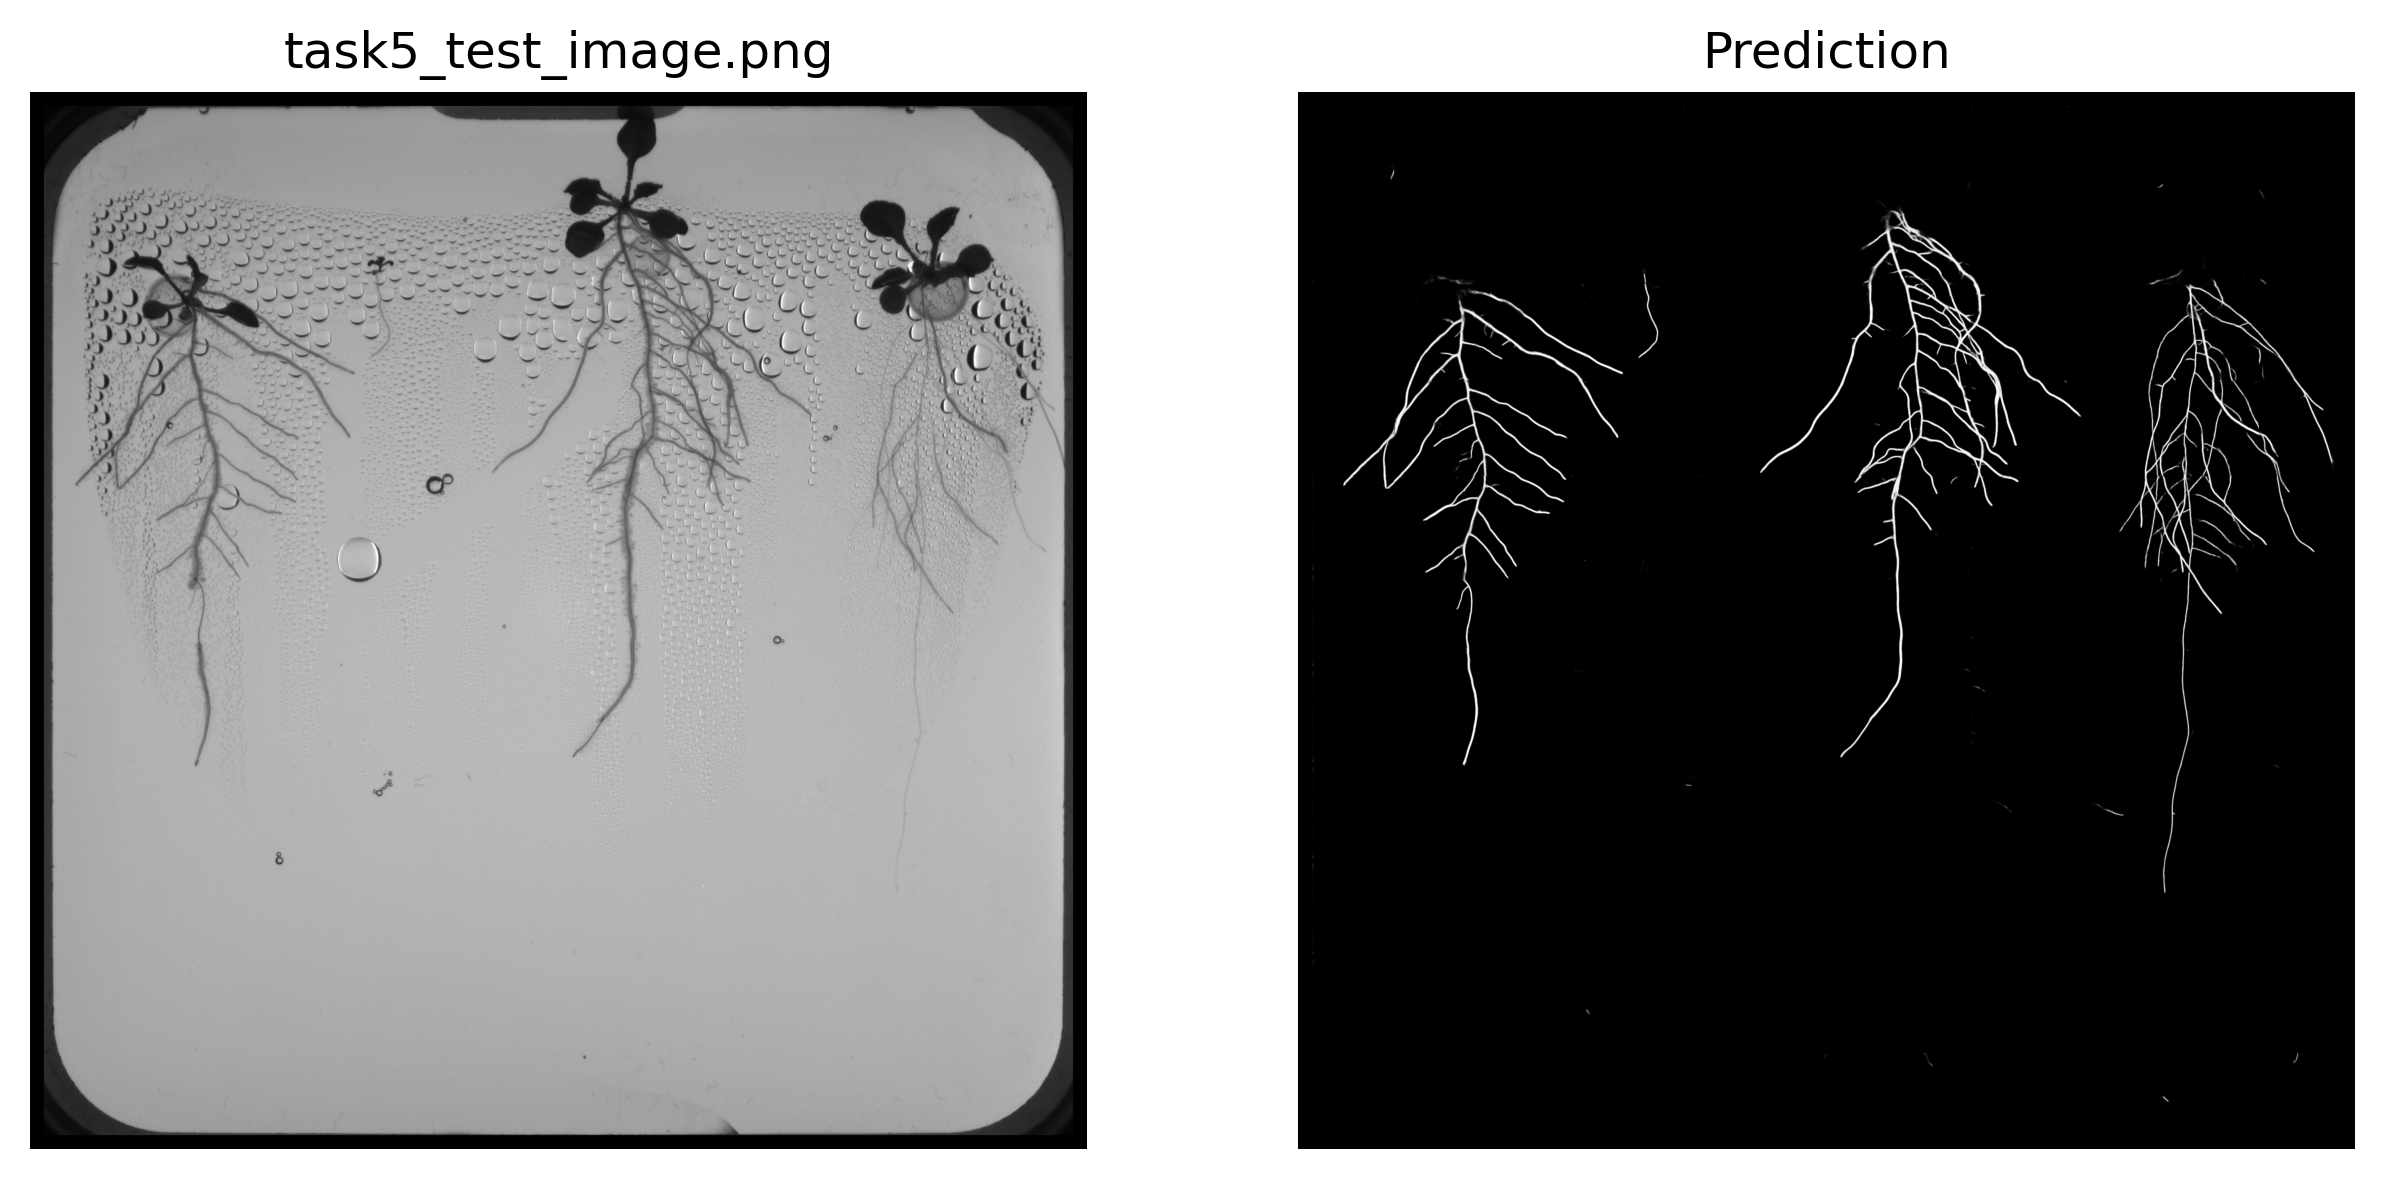

In [8]:
# PATCH
patches = patchify(petri_dish_padded, (patch_size, patch_size), step=128)
patches_shape = patches.shape
# Reshape for model prediction
patches_reshaped = patches.reshape(-1, patch_size, patch_size, 1)
patches_normalized = patches_reshaped / 255.0

# PREDICT
predictions = model.predict(patches_normalized, verbose=1)
predictions = predictions.squeeze()  # Remove single channel dim
predictions = predictions.reshape(patches_shape[0], patches_shape[1], patch_size, patch_size)

# UNPATCH
predicted_mask = unpatchify(predictions, petri_dish_padded.shape)

f, ax = plt.subplots(1, 2, dpi=300, figsize=(10, 5))
ax[0].imshow(petri_dish_padded, cmap='gray')
ax[0].axis('off')
ax[0].set_title('task5_test_image.png')
ax[1].imshow(predicted_mask, cmap='gray')
ax[1].axis('off')
ax[1].set_title('Prediction')

In [9]:
predicted_mask.shape, image.shape

((2816, 2816), (3006, 4112))

As you can see `predicted_mask` and `image` have different shapes. This is because of cropping and padding.

**REQUIREMENT:** The input and output should have the same size and should be aligned perfectly. To achieve this, you need to reverse the effects of cropping and padding added during processing. This will ensure the final mask aligns with the original image.

In [16]:
# Apply the corrections
# Unpad and uncrop the prediction
petri_dish_unpadded = unpadder(predicted_mask, pad_info)
final_mask = uncropper(petri_dish_unpadded, crop_info)

final_mask.shape

(3006, 4112)

(-0.5, 4111.5, 3005.5, -0.5)

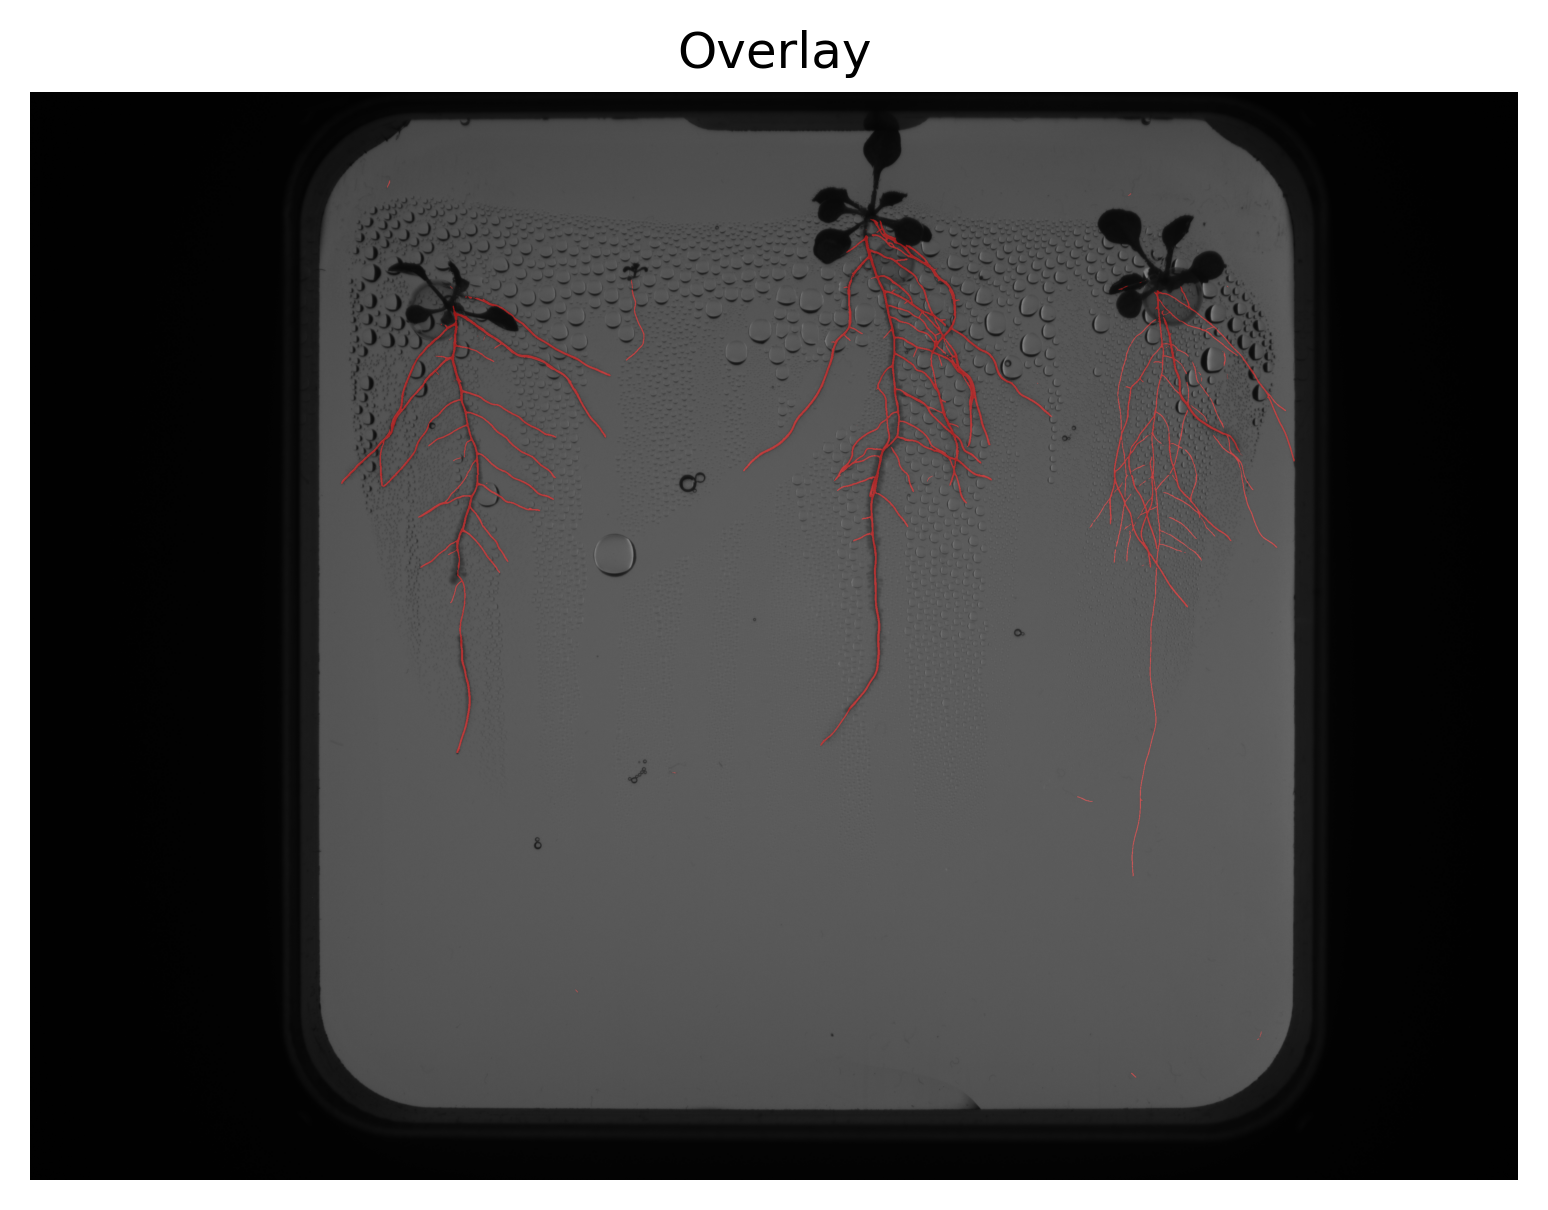

In [28]:
# REQUIREMENT: Predicted roots must align with the original image.
# REQUIREMENT: Plot such an image to prove alignment.
# Binarize the mask to 0 or 255
final_mask_bin = (final_mask > 0.5).astype(np.uint8) * 255

# Load the original image in color
original_image = cv2.imread(task5_test_image_path)
original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

# Create a color version of the binary mask
mask_color = np.zeros_like(original_image_rgb, dtype=np.uint8)
mask_color[:, :, 0] = final_mask_bin # Set the red channel to the mask

# Create the overlay by blending the original image and the colored mask
alpha = 0.5 # Transparency factor
overlay = cv2.addWeighted(original_image_rgb, 1-alpha, mask_color, alpha, 0)

# Display the results
plt.figure(dpi=300)
plt.imshow(overlay)
plt.title('Overlay')
plt.axis('off')

In [ ]:
# REQUIREMENT: Save the predicted mask, it is a deliverable.
# REQUIREMENT: Input/Output size must be the same.
# REQUIREMENT: Predicted roots must align with the original image.
# REQUIREMENT: The predicted mask must be binary.
# REQUIREMENT: Non-root pixels must be 0, root pixels must be 255 (unlike Task 1)
# REQUIREMENT: naming convention task5_test_image_prediction_studentname_studentnumber.png
mask_image = (final_mask * 255).astype(np.uint8)
assert(final_mask.shape == image.shape)
cv2.imwrite('task5_test_image_prediction_daria_236578.png', mask_image)

True

Note: I have trained the model on the Y2B_23 dataset, since there are no labels for Y2B_24 dataset yet. The test image is from Y2B_24, this is why the predicted mask is suboptimal. Therefore do not take the performance of this prediction as a reference. Your predictions should be much better than this.